In [1]:
!pip install requests

In [2]:
import requests
import zipfile
import os

# URLs of the files to download
urls = [
    "https://s3.us.cloud-object-storage.appdomain.cloud/cf-courses-data/CognitiveClass/DL0110EN/edx_project/circle.zip",
    "https://s3.us.cloud-object-storage.appdomain.cloud/cf-courses-data/CognitiveClass/DL0110EN/edx_project/square.zip",
    "https://s3.us.cloud-object-storage.appdomain.cloud/cf-courses-data/CognitiveClass/DL0110EN/edx_project/star.zip",
    "https://s3.us.cloud-object-storage.appdomain.cloud/cf-courses-data/CognitiveClass/DL0110EN/edx_project/triangle.zip"
]

# Function to download a file from a URL
def download_file(url):
    local_filename = url.split('/')[-1]  # Extract the file name from the URL
    with requests.get(url, stream=True) as response:
        with open(local_filename, 'wb') as file:
            # Write the file in chunks to handle large files efficiently
            for chunk in response.iter_content(chunk_size=8192):
                file.write(chunk)
    return local_filename  # Return the local file name for further processing

# Function to unzip a file
def unzip_file(filename):
    with zipfile.ZipFile(filename, 'r') as zip_ref:
        zip_ref.extractall()  # Extract all contents of the zip file
    os.remove(filename)  # Remove the zip file after extraction to save space

# Download and unzip each file from the list of URLs
for url in urls:
    print(f"Downloading {url}")
    filename = download_file(url)  # Download the file and get the local file name
    print(f"Unzipping {filename}")
    unzip_file(filename)  # Unzip the downloaded file

print("All files downloaded and extracted successfully.")  # Final status message



Unzipping circle.zip
Unzipping square.zip
Unzipping star.zip
Unzipping triangle.zip
All files downloaded and extracted successfully.


In [12]:
# PyTorch main library and neural network module
import torch
import torch.nn as nn

# Torchvision module for data transformations
import torchvision.transforms as transforms

# Utilities for handling datasets and data loaders
from torch.utils.data import Dataset, DataLoader, random_split

# Matplotlib for plotting and visualization
import matplotlib.pyplot as plt
import numpy as np
import os  # For file and directory operations
from matplotlib.pyplot import imshow  # Specific import from matplotlib for displaying images
from PIL import Image  # For image processing
import time  # For measuring execution time
from torchvision import datasets  # For standard datasets
import torch.nn.functional as F  # For using various neural network functions
import torch.optim as optim  # For optimization algorithms

In [14]:
!pip uninstall torchvision torch -y
!pip install torch torchvision


Found existing installation: torchvision 0.17.2
Uninstalling torchvision-0.17.2:
  Successfully uninstalled torchvision-0.17.2
Found existing installation: torch 2.2.2
Uninstalling torch-2.2.2:
  Successfully uninstalled torch-2.2.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 MB 11.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 11.4 MB/s eta 0:00:00a 0:00:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fastai 2.7.14 requires torch<2.3,>=1.10, but you have torch 2.3.1 which is incompatible.


In [3]:
# Define the function for plotting the channels

def plot_channels(W):
    n_out = W.shape[0]  # Number of output channels
    n_in = W.shape[1]  # Number of input channels
    w_min = W.min().item()  # Minimum weight value
    w_max = W.max().item()  # Maximum weight value
    fig, axes = plt.subplots(n_out, n_in)  # Create subplots for each channel
    fig.subplots_adjust(hspace=0.1)  # Adjust spacing between plots
    out_index = 0  # Initialize output channel index
    in_index = 0  # Initialize input channel index
    
    # Plot outputs as rows and inputs as columns 
    for ax in axes.flat:
        if in_index > n_in-1:  # Move to the next row if current input channel exceeds limit
            out_index = out_index + 1
            in_index = 0
        # Display the weights for the given output and input channel
        ax.imshow(W[out_index, in_index, :, :], vmin=w_min, vmax=w_max, cmap='seismic')
        ax.set_yticklabels([])  # Remove y-axis tick labels
        ax.set_xticklabels([])  # Remove x-axis tick labels
        in_index = in_index + 1  # Increment input channel index

    plt.show()  # Display the plot


In [16]:
# Define the function for plotting the parameters

def plot_parameters(W, number_rows=1, name="", i=0):
    W = W.data[:, i, :, :]  # Extract the weights for the i-th input channel
    n_filters = W.shape[0]  # Number of filters (output channels)
    w_min = W.min().item()  # Minimum weight value
    w_max = W.max().item()  # Maximum weight value
    fig, axes = plt.subplots(number_rows, n_filters // number_rows)  # Create subplots
    fig.subplots_adjust(hspace=0.4)  # Adjust spacing between plots

    for i, ax in enumerate(axes.flat):
        if i < n_filters:
            ax.set_xlabel("kernel:{0}".format(i + 1))  # Set the label for the sub-plot

            # Plot the filter
            ax.imshow(W[i, :], vmin=w_min, vmax=w_max, cmap='seismic')
            ax.set_xticks([])  # Remove x-axis ticks
            ax.set_yticks([])  # Remove y-axis ticks
    plt.suptitle(name, fontsize=10)  # Set the title for the plot
    plt.show()  # Display the plot


In [17]:
# Define the function for plotting the activations

def plot_activations(A, number_rows=1, name="", i=0):
    A = A[0, :, :, :].detach().numpy()  # Convert the activations of the i-th example to numpy array
    n_activations = A.shape[0]  # Number of activation maps
    A_min = A.min().item()  # Minimum activation value
    A_max = A.max().item()  # Maximum activation value
    fig, axes = plt.subplots(number_rows, n_activations // number_rows)  # Create subplots
    fig.subplots_adjust(hspace=0.4)  # Adjust spacing between plots

    for i, ax in enumerate(axes.flat):
        if i < n_activations:
            ax.set_xlabel("activation:{0}".format(i + 1))  # Set the label for the sub-plot

            # Plot the activation map
            ax.imshow(A[i, :], vmin=A_min, vmax=A_max, cmap='seismic')
            ax.set_xticks([])  # Remove x-axis ticks
            ax.set_yticks([])  # Remove y-axis ticks
    plt.show()  # Display the plot


In [18]:
def show_data(data_sample):
    # Display an image sample with its corresponding label
    plt.imshow(data_sample[0].numpy().reshape(IMAGE_SIZE, IMAGE_SIZE), cmap='gray')  # Reshape and display the image in grayscale
    plt.title('y = ' + str(data_sample[1].item()))  # Set the title to show the label of the image


In [19]:
class Dataset(Dataset):

    # Constructor
    def __init__(self, transform=None, train=True):
        
        # Image directory
        current_working_directory = os.getcwd()

        folders_list = ['square', 'triangle', 'star', 'circle']  # List of folder names
        class_of_folder = [0, 1, 2, 3]  # Corresponding class labels
        path_of_folders = [os.path.join(current_working_directory, file) for file in folders_list]  # Full paths to each folder
        count = 0

        # Create a list of (class_label, image_path) tuples for all images in the folders
        self.sqare_list = [
            (class_label, os.path.join(path_of_folder, file_name))
            for class_label, path_of_folder in zip(class_of_folder, path_of_folders)
            for file_name in os.listdir(path_of_folder) if file_name.endswith(".png")
        ]

        self.transform = transform
        
        # Split data into training and validation sets
        if train:
            # Use 75% of the data for training
            self.sqare_list = [self.sqare_list[i] for i in range(len(self.sqare_list)) if i % 4 != 0]
        else:
            # Use 25% of the data for validation
            self.sqare_list = self.sqare_list[::4]
        
        self.len = len(self.sqare_list)  # Length of the dataset

    def __len__(self):
        return self.len  # Return the number of samples in the dataset
    
    # Getter
    def __getitem__(self, idx):
        
        y, image_path = self.sqare_list[idx]  # Get class label and image path for the given index

        # Open image file
        image = Image.open(image_path)

        # Convert class label to tensor
        y = torch.tensor(y)
        
        # If there is any transform method, apply it onto the image
        if self.transform:
            image = self.transform(image)

        return image, y  # Return the image and its class label

    

In [20]:
#Hint
#IMAGE_SIZE = 16
#[transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)), transforms.ToTensor()]
#transforms.Compose(PLACE TRANSFORMS HERE)

IMAGE_SIZE = 16

transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor()
])
train_dataset = Dataset(transform=transform, train=True)

indices = [100, 3000, 6000, 7000, 10000]
for idx in indices:
    _, label = train_dataset[idx]
    print(f"Sample {idx} has class {label.item()}")


Sample 100 has class 0
Sample 3000 has class 1
Sample 6000 has class 2
Sample 7000 has class 2
Sample 10000 has class 3


In [20]:
#Hint
#IMAGE_SIZE = 16
#[transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)), transforms.ToTensor()]
#transforms.Compose(PLACE TRANSFORMS HERE)

IMAGE_SIZE = 16

transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor()
])
train_dataset = Dataset(transform=transform, train=True)

indices = [100, 3000, 6000, 7000, 10000]
for idx in indices:
    _, label = train_dataset[idx]
    print(f"Sample {idx} has class {label.item()}")


Sample 100 has class 0
Sample 3000 has class 1
Sample 6000 has class 2
Sample 7000 has class 2
Sample 10000 has class 3


In [20]:
IMAGE_SIZE = 16  # Define the desired image size

# Define the transformation pipeline: resize the images and convert them to tensors
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor()
])

# Create an instance of the Dataset class for the training data with the specified transformations
train_dataset = Dataset(transform=transform, train=True)

# Define a list of indices to sample from the dataset
indices = [100, 3000, 6000, 7000, 10000]

# Iterate over the list of indices and print the class label for each corresponding sample
for idx in indices:
    _, label = train_dataset[idx]
    print(f"Sample {idx} has class {label.item()}")



Sample 100 has class 0
Sample 3000 has class 1
Sample 6000 has class 2
Sample 7000 has class 2
Sample 10000 has class 3


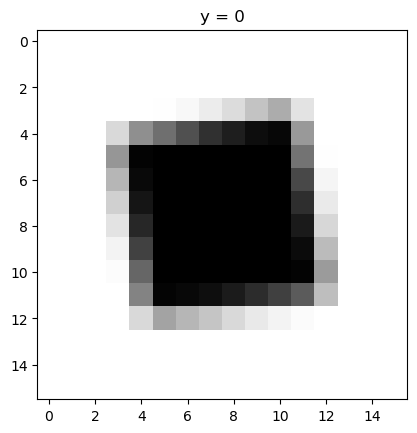

In [21]:
show_data(train_dataset[100])

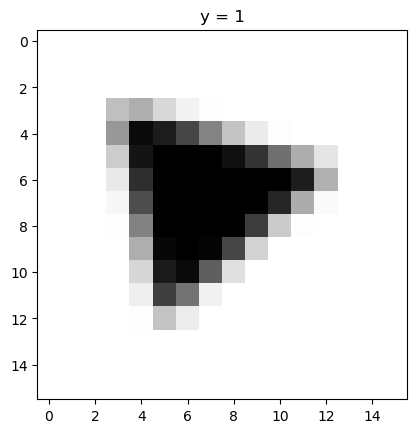

In [22]:
show_data(train_dataset[3000])

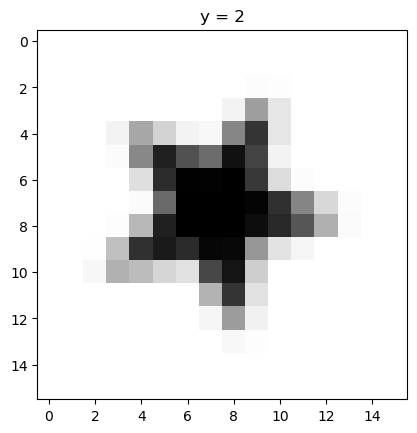

In [23]:
show_data(train_dataset[6000])

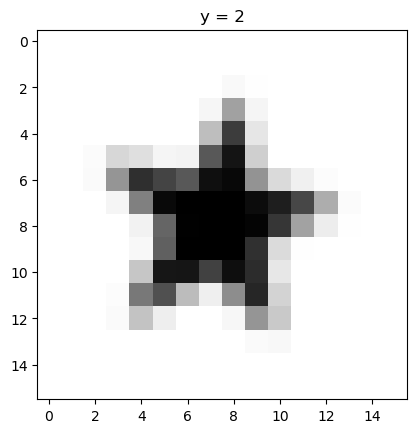

In [24]:
show_data(train_dataset[7000])

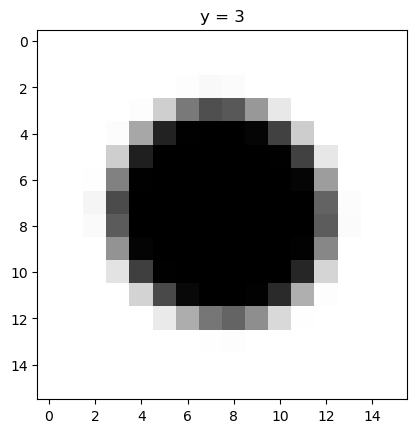

In [25]:
show_data(train_dataset[10000])

In [26]:
IMAGE_SIZE = 16  # Define the desired image size

# Compose the transforms
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),  # Resize images to the specified size
    transforms.ToTensor()  # Convert images to tensor format
])

# Create the validation/test dataset with the specified transformations
test_dataset = Dataset(transform=transform, train=False)


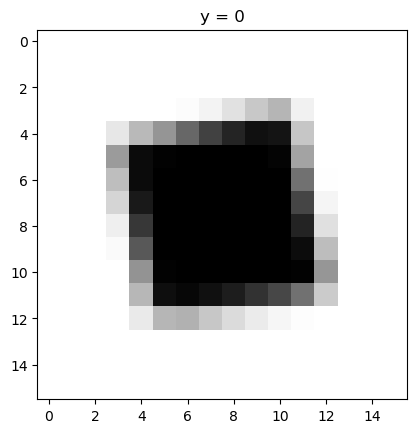

In [27]:
show_data(test_dataset[10])

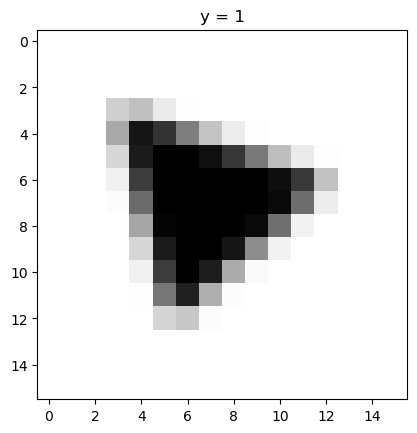

In [28]:
show_data(test_dataset[1500])

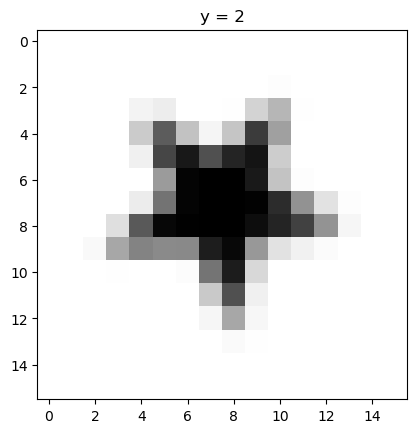

In [29]:
show_data(test_dataset[2000])


In [30]:
class CNN(nn.Module):
    
    # Constructor
    def __init__(self, out_1=16, out_2=32, num_classes=4):
        super(CNN, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=out_1, kernel_size=5, padding=2)  # First convolutional layer
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)  # First max pooling layer
        self.cnn2 = nn.Conv2d(in_channels=out_1, out_channels=out_2, kernel_size=5, stride=1, padding=2)  # Second convolutional layer
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)  # Second max pooling layer
        self.fc1 = nn.Linear(out_2 * 4 * 4, num_classes)  # Fully connected layer
    
    # Prediction
    def forward(self, x):
        x = self.cnn1(x)  # Apply first convolutional layer
        x = torch.relu(x)  # Apply ReLU activation
        x = self.maxpool1(x)  # Apply first max pooling layer
        x = self.cnn2(x)  # Apply second convolutional layer
        x = torch.relu(x)  # Apply ReLU activation
        x = self.maxpool2(x)  # Apply second max pooling layer
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.fc1(x)  # Apply fully connected layer
        return x
    
    # Outputs in each step
    def activations(self, x):
        # Outputs activation, this is not necessary
        z1 = self.cnn1(x)  # First convolutional layer output
        a1 = torch.relu(z1)  # First ReLU activation
        out = self.maxpool1(a1)  # First max pooling layer output
        
        z2 = self.cnn2(out)  # Second convolutional layer output
        a2 = torch.relu(z2)  # Second ReLU activation
        out1 = self.maxpool2(a2)  # Second max pooling layer output
        out = out.view(out.size(0), -1)  # Flatten the tensor
        return z1, a1, z2, a2, out1, out  # Return intermediate activations


In [31]:
# Create the model object using CNN class

model=CNN()


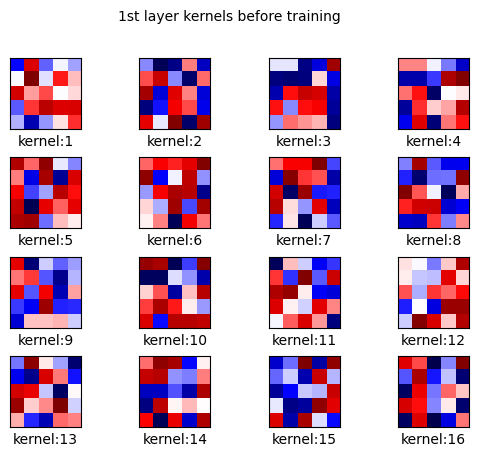

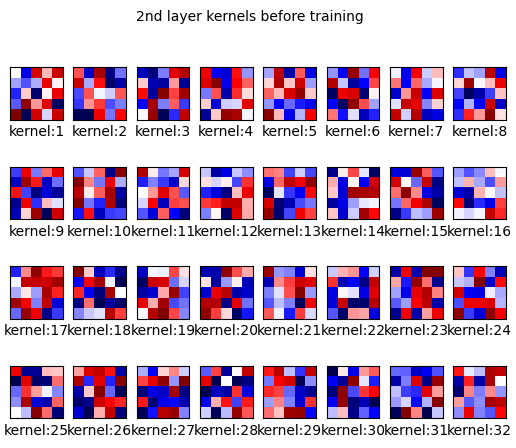

In [32]:
# Plot the parameters

plot_parameters(model.state_dict()['cnn1.weight'], number_rows=4, name="1st layer kernels before training ")
plot_parameters(model.state_dict()['cnn2.weight'], number_rows=4, name='2nd layer kernels before training' )


In [33]:
model(train_dataset[0][0].unsqueeze(0))


tensor([[ 0.0590, -0.0302, -0.0618, -0.0159]], grad_fn=<AddmmBackward0>)

In [35]:
# Setup the parameters for training
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Create DataLoader objects for training and validation
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=5000, shuffle=True)
validation_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=5000, shuffle=False)

In [4]:
# Training the model

n_epochs = 120  # Number of epochs to train the model
cost_list = []  # List to store the cost at each epoch
accuracy_list = []  # List to store the accuracy at each epoch
N_test = len(test_dataset)  # Number of samples in the test dataset
start_time = time.time()  # Record the start time

# Training loop
for epoch in range(n_epochs):
    COST = 0  # Initialize cost for the current epoch
    
    # Training phase
    for x, y in train_loader:
        optimizer.zero_grad()  # Zero the gradients
        z = model(x)  # Forward pass
        loss = criterion(z, y)  # Compute the loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update the weights
        COST += loss.data  # Accumulate the loss

    cost_list.append(COST)  # Store the accumulated cost for the epoch
    correct = 0  # Initialize correct predictions count

    # Validation phase: perform a prediction on the validation data
    for x_test, y_test in validation_loader:
        z = model(x_test)  # Forward pass
        _, yhat = torch.max(z.data, 1)  # Get the predicted class
        correct += (yhat == y_test).sum().item()  # Count correct predictions
    
    accuracy = correct / N_test  # Compute accuracy
    accuracy_list.append(accuracy)  # Store accuracy for the epoch

# Print total training time
print(f"Training time: {time.time() - start_time} seconds")



NameError: name 'test_dataset' is not defined

The provided code sets up and trains a Convolutional Neural Network (CNN) using PyTorch for a multi-class image classification task. The CNN architecture includes two convolutional layers followed by ReLU activations and max pooling layers, culminating in a fully connected layer for classification. Images are preprocessed using torchvision transforms to resize them and convert them to tensor format. The dataset class is designed to handle the custom dataset, segregating it into training and validation sets. The training loop iterates over a defined number of epochs, performing forward passes, loss computation using a specified criterion, backpropagation, and weight updates using an optimizer. After each epoch, the model's performance is evaluated on the validation set, recording the cost and accuracy. The training process is timed, and the results are stored for further analysis, allowing for tracking the model's learning progression over the epochs.